# Dataset Preprocessing

In [1]:
# While Model training
# 1. --- Print model summary (trainable, non-trainable, total parameters) 
# 2. --- while compiling the model, add other metrics like roc_auc score, precision, recall,f1-score,specifity,sensivity,accuracy,loss (training and validation both)
# 3. --- Plot metrics curves VS epochs like mentioned in 2 
# 4. --- Plot confusion matrix like training, validation, test dataset 
# 5. --- Implement early stopping with 100 epochs
# 6. --- records total time (training, testing, validation) and also What GPU you are using it.
# 7. ---- Save the models as well ( .hdf5 format for loading the trained weights)
# 8. ---- keep similar loss functions, optimizers, learning rate, epochs, ...etc

In [2]:
!pip install keras tensorflow

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import os

from glob import glob

import seaborn as sns

from PIL import Image

np.random.seed(123)

from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding

from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from keras import backend as K

import itertools

from keras.layers import BatchNormalization

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding



from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [4]:
dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'

In [5]:
#1. Function to plot model's validation loss and validation accuracy

def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # summarize history for accuracy

    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])

    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])

    axs[0].set_title('Model Accuracy')

    axs[0].set_ylabel('Accuracy')

    axs[0].set_xlabel('Epoch')

    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)

    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])

    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])

    axs[1].set_title('Model Loss')

    axs[1].set_ylabel('Loss')

    axs[1].set_xlabel('Epoch')

    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)

    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

In [6]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
df.shape

(10015, 7)

In [9]:
lesion_type_dict = {

    'nv': 'Melanocytic nevi',

    'mel': 'Melanoma',

    'bkl': 'Benign keratosis-like lesions ',

    'bcc': 'Basal cell carcinoma',

    'akiec': 'Actinic keratoses',

    'vasc': 'Vascular lesions',

    'df': 'Dermatofibroma'

}

base_skin_dir = '/kaggle/input/skin-cancer-mnist-ham10000'

In [10]:
import os

from glob import glob



# Use glob to get a list of file paths

image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))



# Create a dictionary mapping image IDs to file paths

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

In [11]:
df['path'] = df['image_id'].map(imageid_path_dict.get)

df['cell_type'] = df['dx'].map(lesion_type_dict.get)

df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes



df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


In [12]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [13]:
df['age'].fillna((df['age'].mean()), inplace=True)

/tmp/ipykernel_23/1123070014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [14]:
df.isna().sum().sum()

0

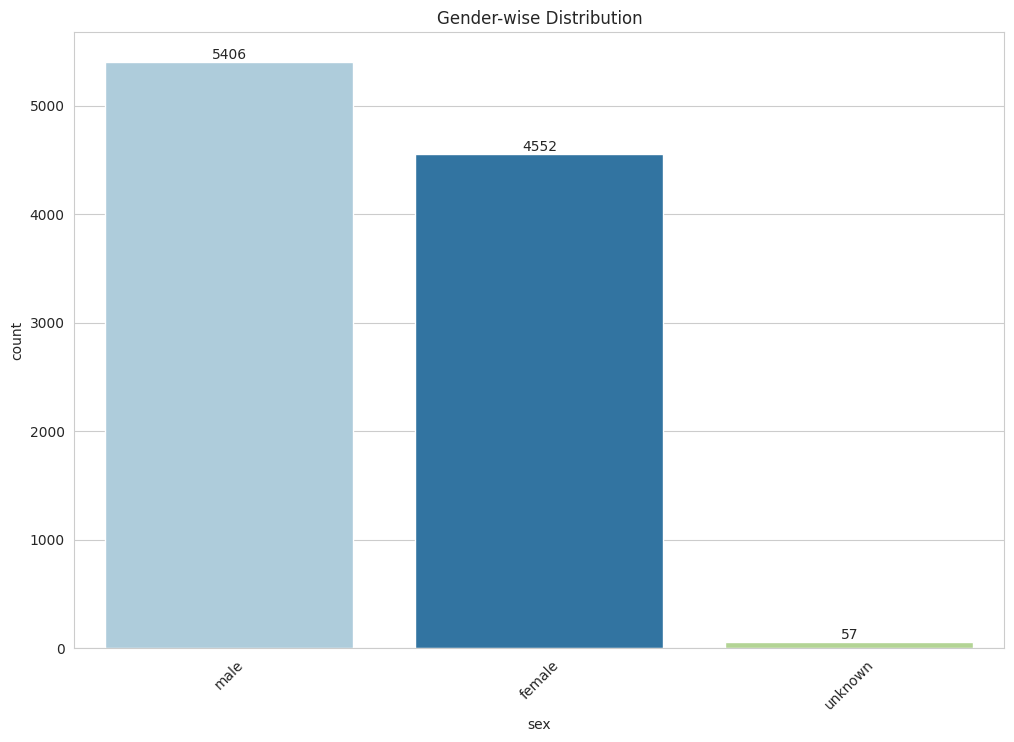

In [15]:
sns.set_style('whitegrid')

colors = ['#87ace8','#e3784d', 'green']

fig,axes = plt.subplots(figsize=(12,8))



ax = sns.countplot(x='sex',data=df, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Gender-wise Distribution')

plt.xticks(rotation=45)

plt.show()

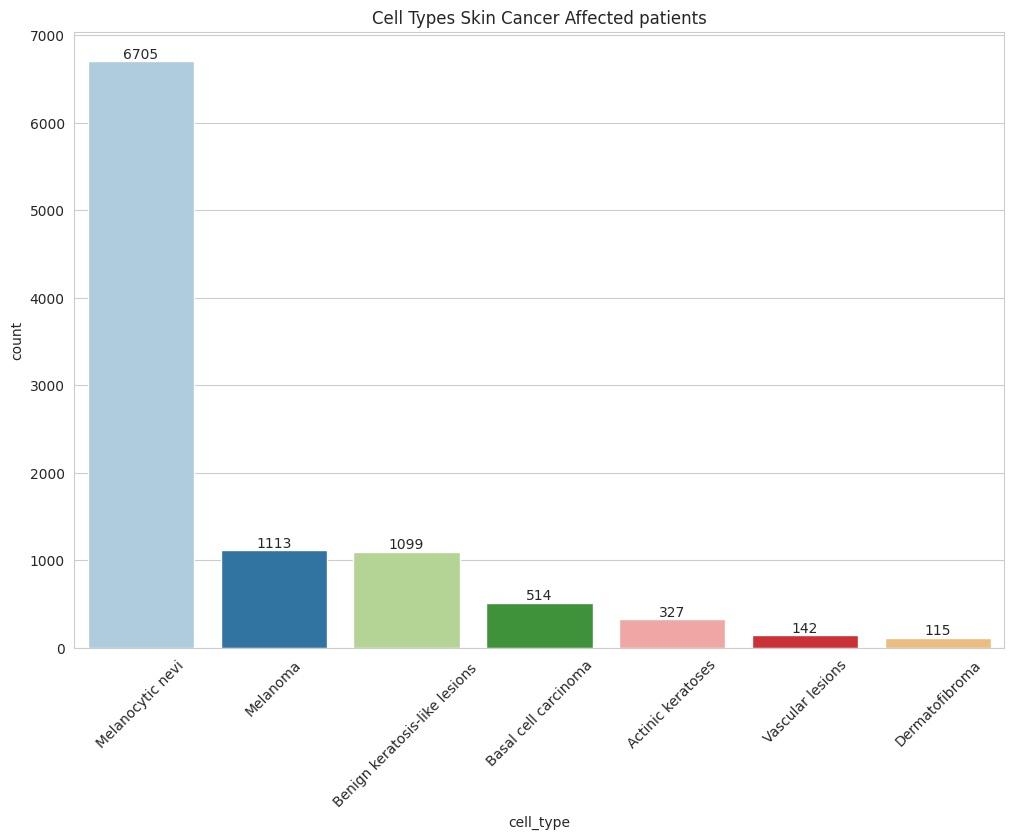

In [16]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Skin Cancer Affected patients')

plt.xticks(rotation=45)

plt.show()

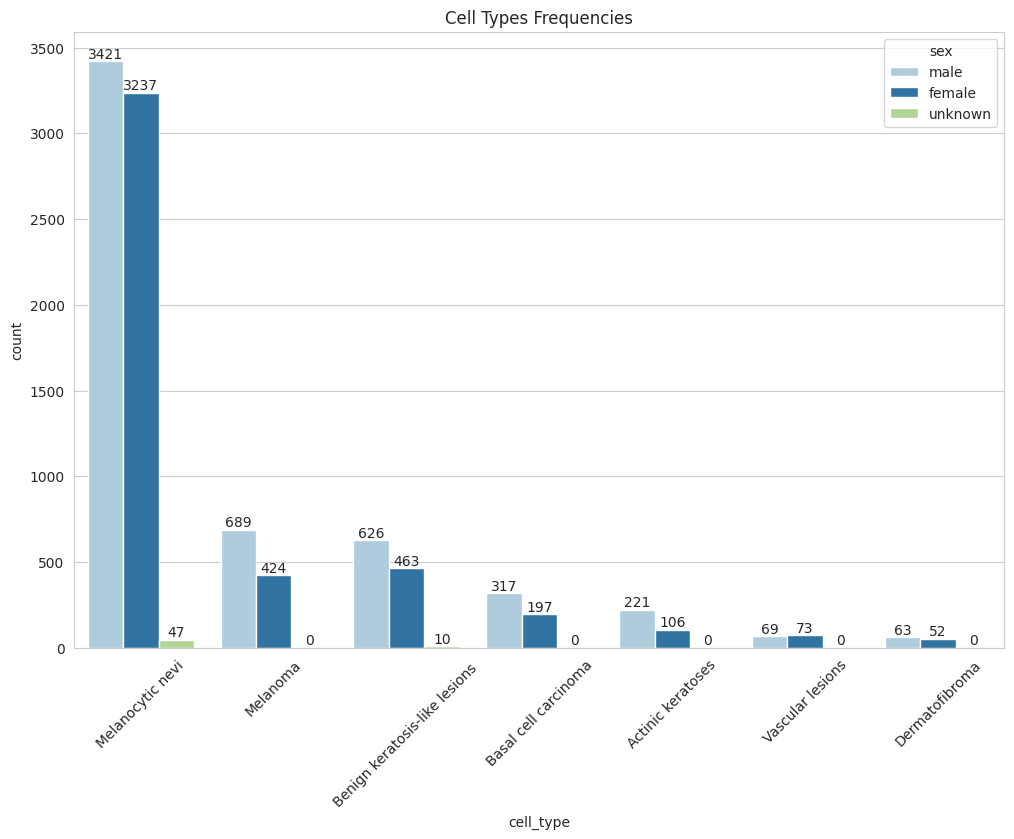

In [17]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

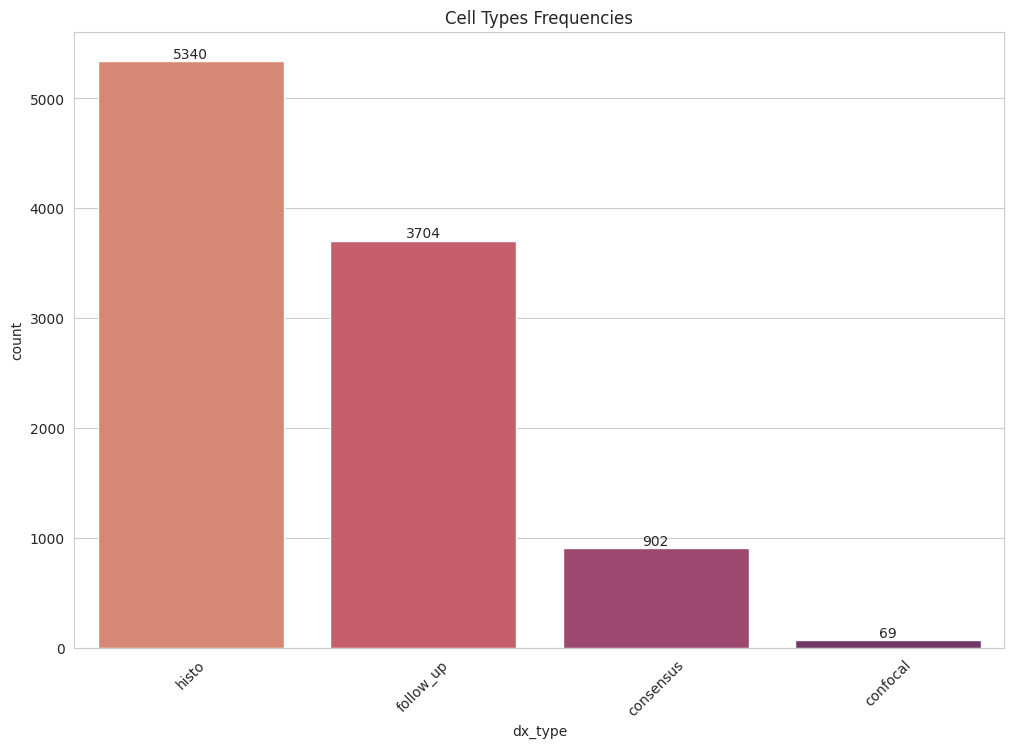

In [18]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

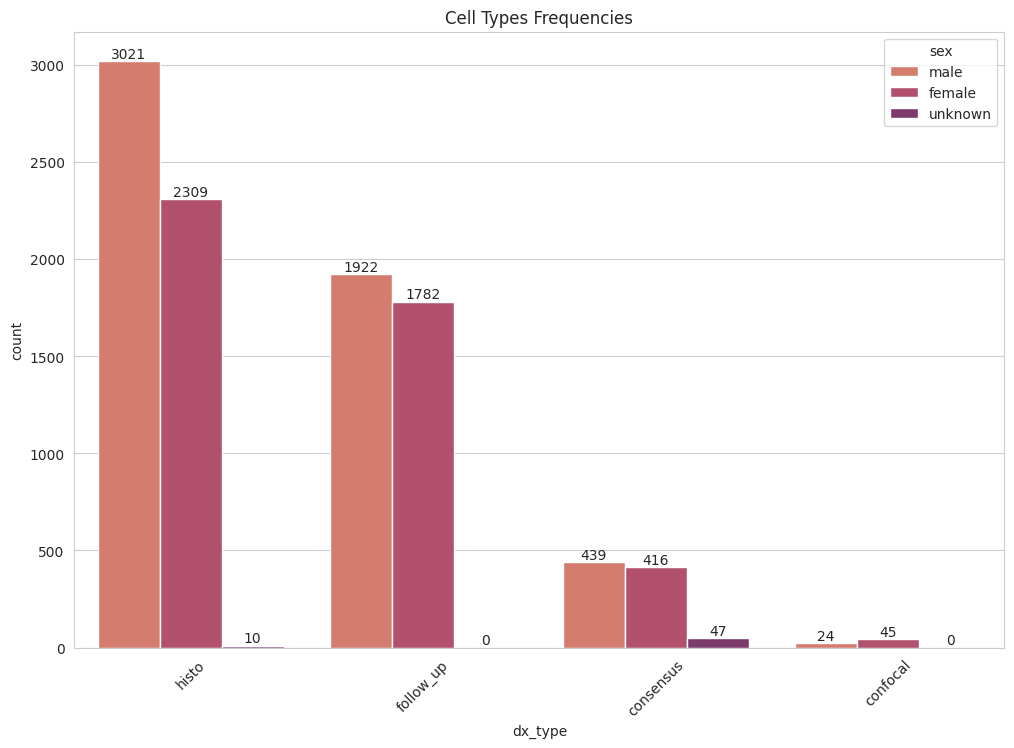

In [19]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


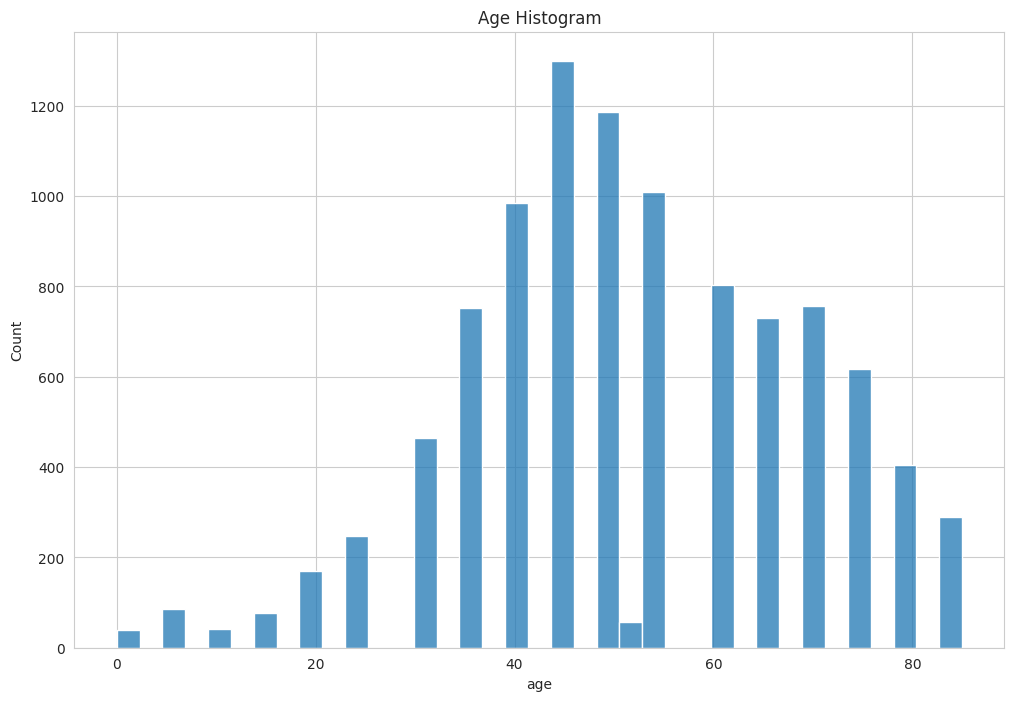

In [20]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.histplot(data=df, x='age')

plt.title('Age Histogram')

plt.show()

In [21]:
size = (64, 64)

df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

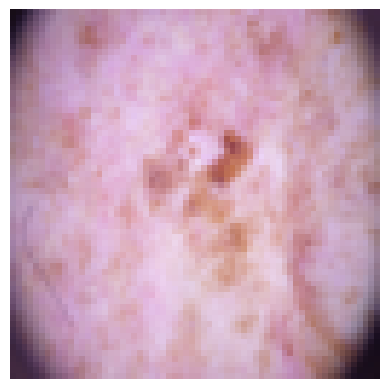

In [22]:
arr = df.iloc[1]['image']

#Image.fromarray(arr)

plt.imshow(arr)

plt.axis('off')

plt.show()

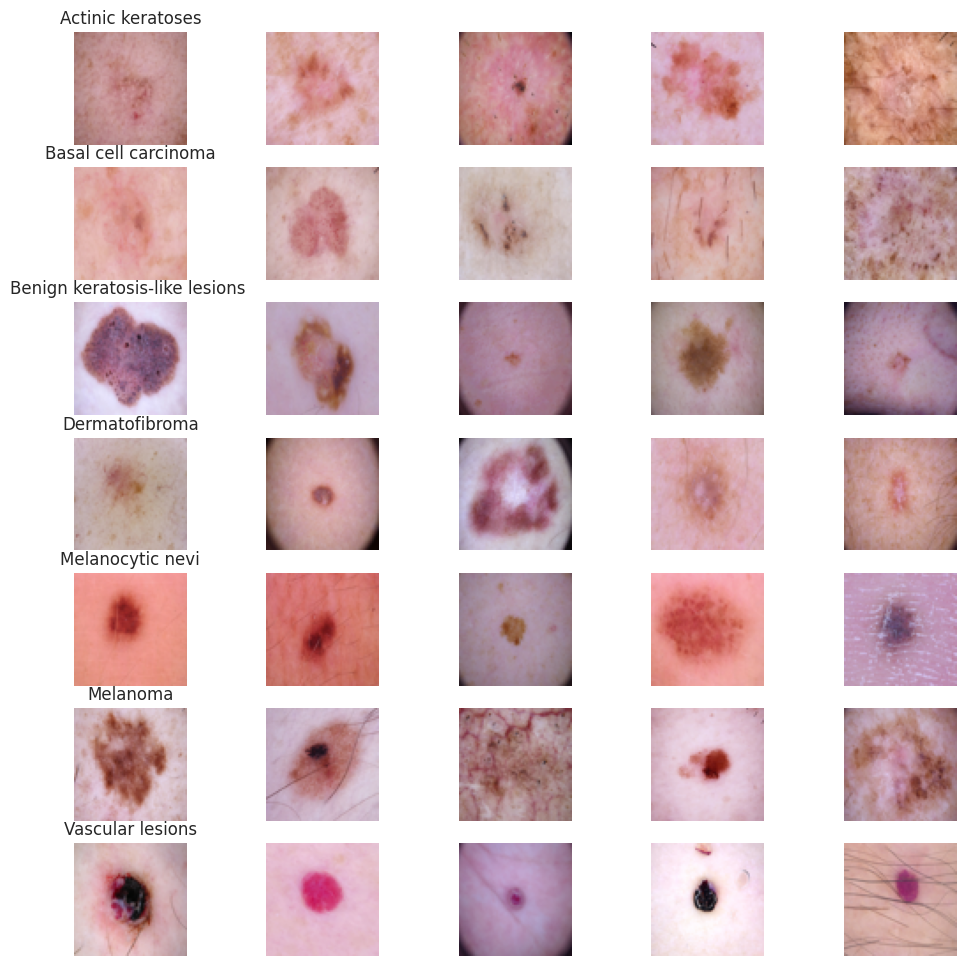

In [23]:
n_samples = 5

fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))

for n_axs, (type_name, type_rows) in zip(m_axs,

                                         df.sort_values(['cell_type']).groupby('cell_type')):

    n_axs[0].set_title(type_name)

    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):

        c_ax.imshow(c_row['image'])

        c_ax.axis('off')

# fig.savefig('category_samples.png', dpi=300)

In [24]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [25]:
def aug_brightness(img_arr):

    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [26]:
def aug_contrast(img_arr):

    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [27]:
def aug_flip_left_right(img_arr):

    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()

    aur_arr = np.array(aug_arr)



    return aug_arr

In [28]:
def aug_flip_up_down(img_arr):

    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()

    aur_arr = np.array(aug_arr)



    return aug_arr

In [29]:
def aug_hue(img_arr):

    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [30]:
def aug_saturation(img_arr):

    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [31]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [32]:
from IPython.display import clear_output

def random_augmentation(images, dx, num_of_samples):

    new_images = []

    all_indices = []

    while (len(new_images) < num_of_samples):

        indices = np.random.randint(images.shape[0], size=6)

        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))

        r = [np.array(tensor) for tensor in r]

        new_images.extend(r)

        all_indices.extend(indices)

        clear_output(wait=True)

        print(str(len(new_images)) + '/' + str(num_of_samples))



    new_images = pd.DataFrame({'dx': dx, 'image': new_images})



    return all_indices, new_images

In [33]:
nv_df = df[df['dx'] == 'nv']

df_df = df[df['dx'] == 'df']

vasc_df = df[df['dx'] == 'vasc']

akiec_df = df[df['dx'] == 'akiec']

bcc_df = df[df['dx'] == 'bcc']

bkl_df = df[df['dx'] == 'bkl']

mel_df = df[df['dx'] == 'mel']

In [34]:
seed = (4,2)

In [35]:
max_count = 10000

nv_count = (df['dx'] == 'nv').sum()

mel_count = (df['dx'] == 'mel').sum()

bkl_count = (df['dx'] == 'bkl').sum()

bcc_count = (df['dx'] == 'bcc').sum()

akiec_count = (df['dx'] == 'akiec').sum()

vasc_count = (df['dx'] == 'vasc').sum()

df_count = (df['dx'] == 'df').sum()

In [36]:
# df_images = df_df['image']

# df_indices, df_new_images = random_augmentation(df_images, 'df', max_count - df_count)

In [37]:
# vasc_images = vasc_df['image']

# vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', max_count - vasc_count)

In [38]:
# akiec_images = akiec_df['image'] 

# akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', max_count - akiec_count)

In [39]:
# bcc_images = bcc_df['image']

# bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', max_count - bcc_count)

In [40]:
# bkl_images = bkl_df['image']

# bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', max_count - bkl_count)

In [41]:
# mel_images = mel_df['image']

# mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', max_count - mel_count)

In [42]:
# nv_images = nv_df['image']

# nv_indices, nv_new_images = random_augmentation(nv_images, 'nv', max_count - nv_count)

In [43]:
# new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images, nv_new_images], axis=0).reset_index(drop=True)

# aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)

# aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [44]:
pd.DataFrame(df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


In [45]:
#aug_df.shape

In [46]:
# for i in range(12, 18):

#     plt.subplot(1, 3, 1)

#     plt.imshow(mel_df['image'].iloc[mel_indices[i]])

#     plt.title('Original')

#     plt.axis('off')



#     plt.subplot(1, 3, 2)

#     plt.imshow(mel_new_images['image'].iloc[i])

#     plt.title('Augmented')

#     plt.axis('off')



#     plt.show()

In [47]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

df['label'] = labelEncoder.fit_transform(df['dx'])

In [48]:
x = np.asarray(df['image'].to_list())

y = to_categorical(df['label'], num_classes=7)



x_train, x_test, y_train, y_test = train_test_split(

    x, y, test_size=0.20, random_state=42, shuffle=True, stratify=y

)

# **Model setup**

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
from keras import backend

In [50]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 64
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.

In [51]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation=keras.activations.swish,
        padding="same",
    )
    return conv_layer(x)


# Reference: https://github.com/keras-team/keras/blob/e3858739d178fe16a0c77ce7fab88b0be6dbbdc7/keras/applications/imagenet_utils.py#L413C17-L435


def correct_pad(inputs, kernel_size):
    img_dim = 2 if backend.image_data_format() == "channels_first" else 1
    input_size = inputs.shape[img_dim : (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if keras.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=0.1,
        )
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [52]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):  # Accept extra arguments
        super().__init__(**kwargs)
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [53]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        """
        Initializes the PatchEncoder layer.
        Args:
            num_patches (int): Total number of patches per image.
            projection_dim (int): Dimensionality of the projection space.
        """
        super(PatchEncoder, self).__init__(**kwargs)  # Pass additional arguments to the base class
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)  # Linear projection
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )  # Positional embeddings
    def call(self, patch):
        """
        Encodes the patches by projecting and adding positional embeddings.
        Args:
            patch (tf.Tensor): A batch of patches with shape (batch_size, num_patches, patch_dims).
        Returns:
            tf.Tensor: Encoded patches with shape (batch_size, num_patches, projection_dim).
        """
        positions = tf.range(start=0, limit=self.num_patches, delta=1)  # [0, 1, 2, ..., num_patches-1]
        positions = self.position_embedding(positions)  # (num_patches, projection_dim)
        projected_patches = self.projection(patch)  # (batch_size, num_patches, projection_dim)
        encoded = projected_patches + positions  # Broadcasting addition
        return encoded
    def get_config(self):
        """
        Returns the configuration of the layer.
        This enables the layer to be serialized.
        Returns:
            dict: Configuration dictionary.
        """
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units
        })
        return config

In [54]:
def mlp(x, hidden_units, dropout_rate):
    """
    Constructs an MLP with the specified hidden units and dropout rate.
    Args:
        x (tf.Tensor): Input tensor.
        hidden_units (list of int): Number of units in each hidden dense layer.
        dropout_rate (float): Dropout rate for regularization.
    Returns:
        tf.Tensor: Output tensor after passing through the MLP.
    """
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)  # relu activation
        x = layers.Dropout(dropout_rate)(x)
    return x

In [55]:
# Hyperparameters
image_size = 64
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 256
num_heads = 8
transformer_units = [512, 256]
mlp_head_units = [1024, 512]
num_transformer_blocks = 2
num_classes = 7
conv_filters = 256
conv_depth = 2
conv_kernel_size = 5
dropout_rate = 0.1

In [56]:
def create_mobilevit(num_classes=7):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [57]:
mobilevit = create_mobilevit()
mobilevit.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu (Silu)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 32, 32,    │        288 │ silu[0][0]        │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_1 (Silu)       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        512 │ silu_1[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        512 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ silu_2 (Silu)       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 33, 33,    │          0 │ silu_2[0][0]      │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 16, 16,    │        288 │ zero_padding2d[0

 Total params: 1,308,263 (4.99 MB)

 Trainable params: 1,305,719 (4.98 MB)

 Non-trainable params: 2,544 (9.94 KB)

In [58]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision_value = self.precision.result()
        recall_value = self.recall.result()
        return 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [59]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam

# Compile the model
mobilevit.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='roc_auc'),
        F1Score(name='f1_score')  
    ]
)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = mobilevit.fit(
    x_train,  # Input data
    y_train,  # Target labels
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1737830461.257840      74 service.cc:145] XLA service 0x7e0dcc0018a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737830461.257906      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/251 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4896 - f1_score: 0.0937 - loss: 1.7279 - precision: 0.1875 - recall: 0.0625 - roc_auc: 0.7222                 

I0000 00:00:1737830547.784777      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6780 - f1_score: 0.6509 - loss: 0.9798 - precision: 0.7750 - recall: 0.5617 - roc_auc: 0.9159

I0000 00:00:1737830638.600305      74 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads



251/251 ━━━━━━━━━━━━━━━━━━━━ 224s 409ms/step - accuracy: 0.6780 - f1_score: 0.6510 - loss: 0.9795 - precision: 0.7751 - recall: 0.5617 - roc_auc: 0.9160 - val_accuracy: 0.6695 - val_f1_score: 0.0000e+00 - val_loss: 1.5223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8344 - learning_rate: 0.0010
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7132 - f1_score: 0.7035 - loss: 0.7922 - precision: 0.8321 - recall: 0.6094 - roc_auc: 0.9469 - val_accuracy: 0.0514 - val_f1_score: 0.0000e+00 - val_loss: 1.8181 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7169 - learning_rate: 0.0010
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7260 - f1_score: 0.7264 - loss: 0.7161 - precision: 0.8305 - recall: 0.6456 - roc_auc: 0.9567 - val_accuracy: 0.6695 - val_f1_score: 0.6695 - val_loss: 6.6963 - val_precision: 0.6695 - val_recall: 0.6695 - val_roc_auc: 0.8072 - learning_rate: 0.0010
Epoch 4/100
251/251 ━━━━━━━━━━━

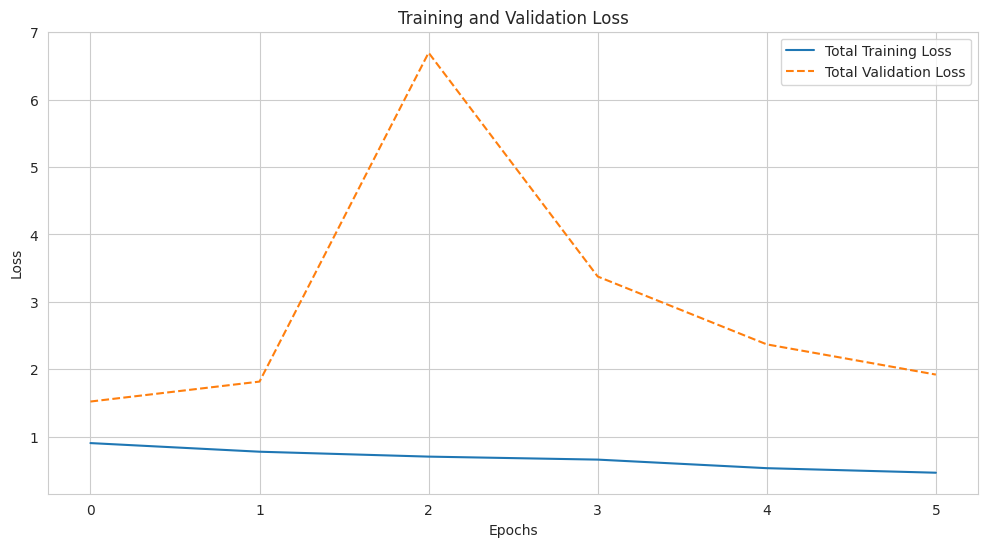

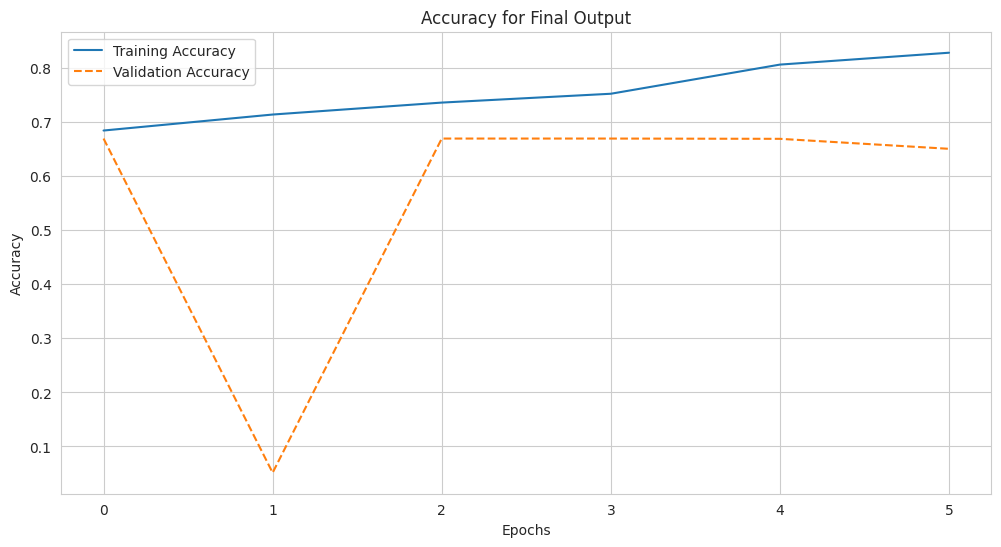

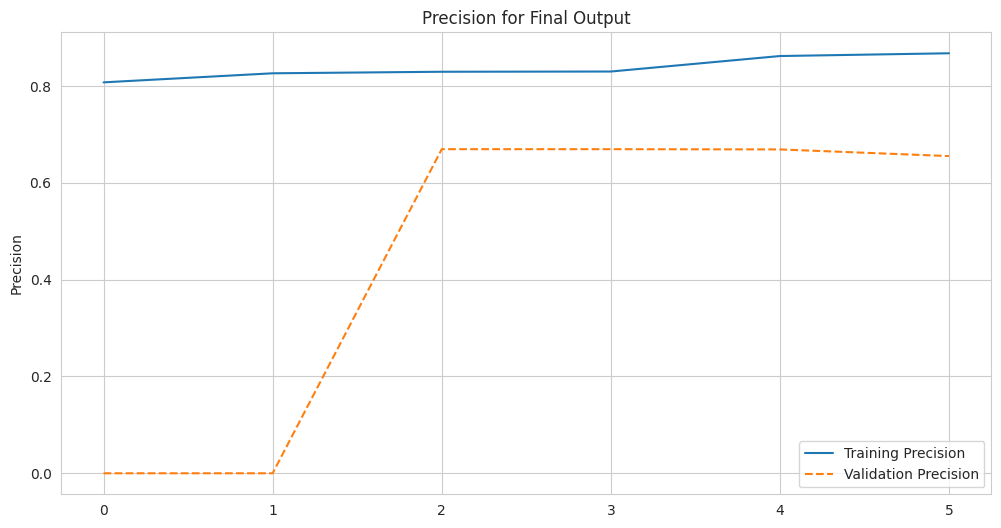

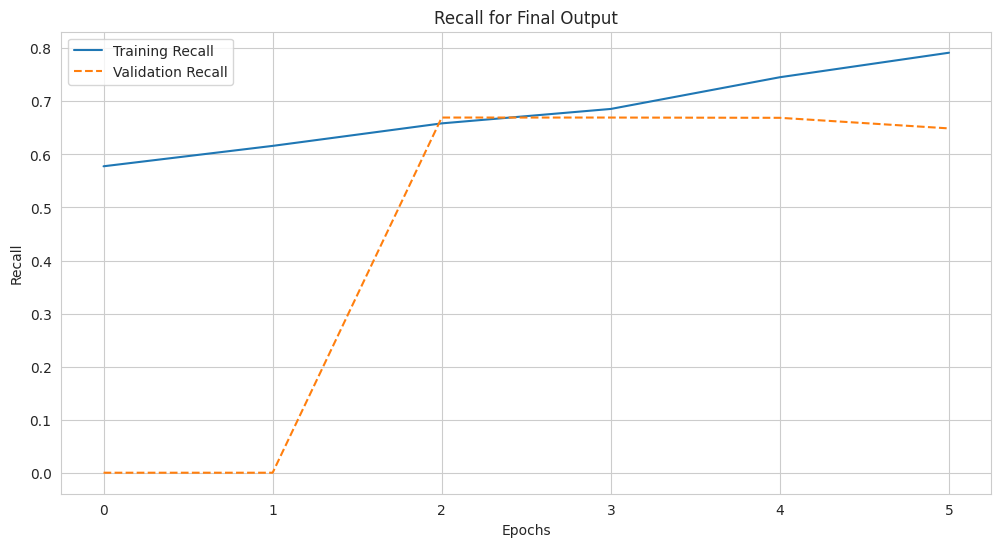

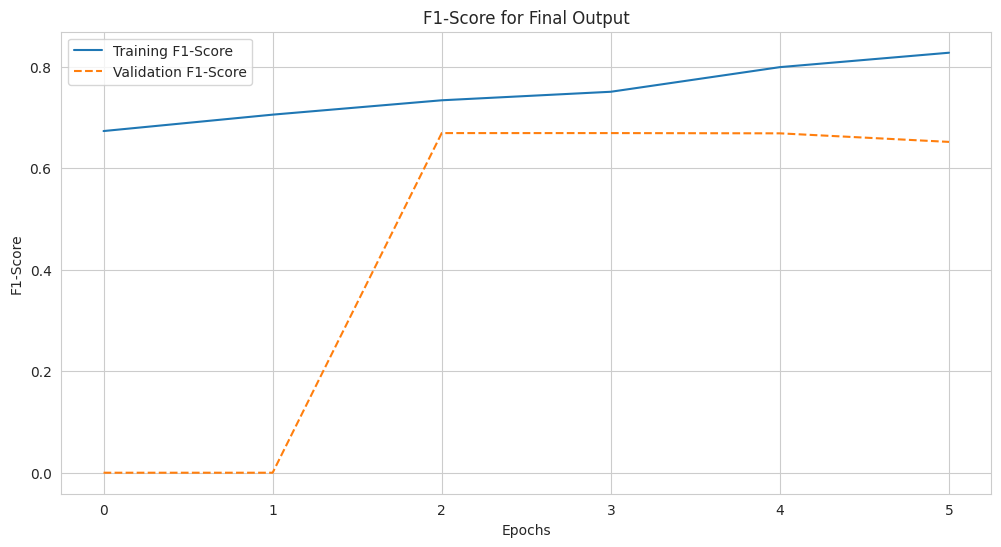

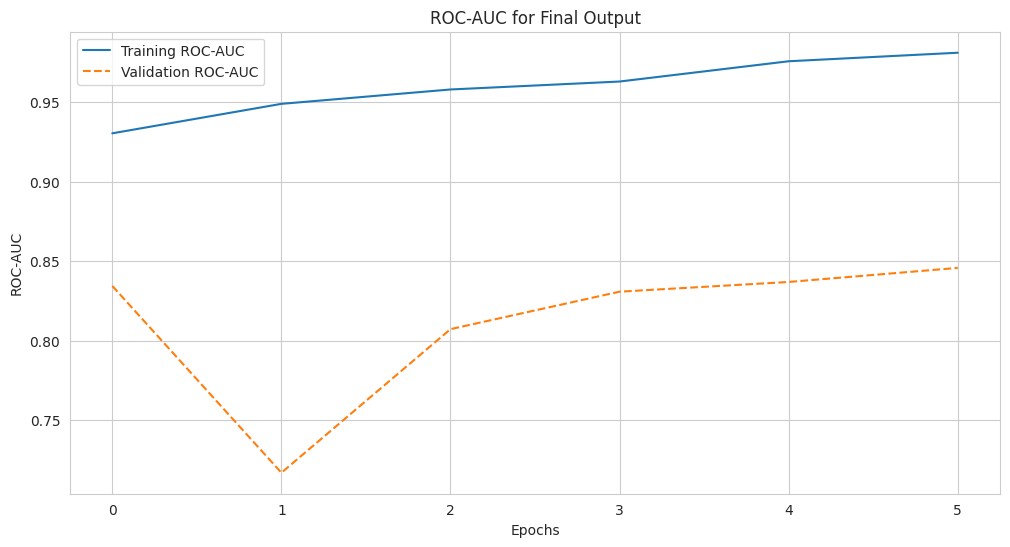

In [61]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Total Training Loss')
plt.plot(history_dict['val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation Accuracy for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision', linestyle='--')
plt.ylabel('Precision')
plt.title('Precision for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['f1_score'], label='Training F1-Score')
plt.plot(history_dict['val_f1_score'], label='Validation F1-Score', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC-AUC for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['roc_auc'], label='Training ROC-AUC')
plt.plot(history_dict['val_roc_auc'], label='Validation ROC-AUC', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC for Final Output')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Evaluate the student model
evaluation_results = mobilevit.evaluate(
    x_test,  # Test inputs
    y_test,  # Target labels for the final output
    verbose=1
)

# Optionally, print the results
print(f"Test Loss: {evaluation_results[0]}")
print(f"Test Accuracy: {evaluation_results[1]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6549 - f1_score: 0.0000e+00 - loss: 1.5353 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.8258
Test Loss: 1.522256851196289
Test Accuracy: 0.6694957613945007


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step


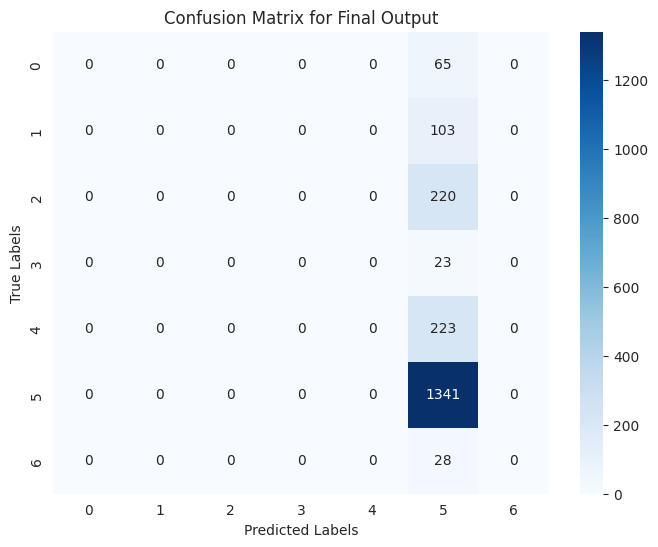

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test dataset
predictions = mobilevit.predict(x_test, verbose=1)

# Use the final output predictions (only one output now)
y_pred_final = predictions  # Only one output, so we use the full predictions array
y_pred_classes = np.argmax(y_pred_final, axis=-1)  # Convert probabilities to class indices

# True labels for final output
y_true_final = np.argmax(y_test, axis=-1)  # Assuming y_test is one-hot encoded

# Generate confusion matrix
cm = confusion_matrix(y_true_final, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), 
            yticklabels=np.arange(cm.shape[0]))
plt.title('Confusion Matrix for Final Output')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()